### Sections

1. Imports
2. Helper Function
3. 2D Chaotic Map
4. Encoding Algorithm
5. Analysis
6. Implementation

# 1. Imports

In [49]:
from PIL import Image
import numpy as np
import cv2
from pylfsr import LFSR
from skimage import io
from matplotlib import pyplot as plt 

# 2. Helper Functions

2.1 Any type to Binary Converter


In [50]:
def convertToBinary(data):
    if isinstance(data, str):
        return ''.join([ format(ord(i), "08b") for i in data ])
    elif isinstance(data, bytes) or isinstance(data, np.ndarray):
        return [ format(i, "08b") for i in data ]
    elif isinstance(data, int) or isinstance(data, np.uint8):
        return format(data, "08b")
    else:
        raise TypeError("Type not supported.")

2.2 Binary to Decimal Converter

In [51]:
def binaryToDecimal(binary):
    decimal = 0
    for bit in binary:
        decimal = decimal*2 + int(bit)
    return decimal

# 3. 2D Chaotic Map

- Hennon Map (Binary)

In [52]:
def HennonMapBinary(dimension, key):

    rows = dimension[0]
    cols = dimension[1]
    x = key[0]
    y = key[1]
    a = 1.4
    b = 0.3

    # Total Number of bitSequence produced
    sequenceSize = rows * cols
    bitSequenceSize = cols
    # Each bitSequence contains k bits
    bitSequence = []       
    # Each matrix contains m*n byteArray
    matrix = []

    for i in range(sequenceSize):
        x_next = y + 1 - (a * (x**2)) 
        y_next = b * x
        x = x_next
        y = y_next
        if x <= 0.4:
            bit = 0
        else:
            bit = 1

        bitSequence.append(bit) 

        # If Bit Sequence has k bits, convert it to decimal and add it to Byte Sequence.
        if i % bitSequenceSize == bitSequenceSize - 1:
            matrix.append(bitSequence)
            bitSequence = []

    return matrix

# 4. Encoding


In [53]:
def encode(imageName, filename, key, poly):

    # read the image.
    imagehandler = Image.open(imageName) 
    image = imagehandler.load()
    image_size = imagehandler.size

    # Get secret data.
    filehandler = open(filename,"r")
    secret_data = "".join(filehandler.readlines())
    secret_data += "=!"
    filehandler.close()

    # convert data to binary.
    binary_secret_data = convertToBinary(secret_data)
    data_len = len(binary_secret_data)

    # Create and load intermediate images.
    intermediate_imagehandler1 = imagehandler.copy()
    intermediate_image1 = intermediate_imagehandler1.load()
    intermediate_imagehandler2 = imagehandler.copy()
    intermediate_image2 = intermediate_imagehandler2.load()

    # Build chaotic map and derive some available pixels.
    map = HennonMapBinary(image_size, key)

    # Select pixels by superimposing Chaotic Map on the image.
    availablePixels = []
    for i in range(image_size[0]):
        for j in range(0,image_size[1]):
            if map[i][j] == 1:
                availablePixels.append([i,j,0])
                intermediate_image1[i,j] = (0,255,0)

    # Save intermediate 1 with selected pixels by Chaotic Map.
    intermediate_imagehandler1.save("outputs/image_steg/intermediate1.png","PNG")

    # check if encoding is possible
    if data_len > len(availablePixels)*6:
        raise ValueError("[!] Insufficient space. Please change key or data.")

    # Build LFSR
    lfsr = LFSR(initstate = [1, 1, 1, 1, 1, 1, 1, 1], fpoly=poly, counter_start_zero=True)

    index = 0

    for i in range(0, data_len, 2):

        # Choose pixel using LFSR from Available pixels
        index = (index + binaryToDecimal(lfsr.state)) % len(availablePixels)
        lfsr.next()

        # If pixel is already used 3 times, keep choosing next pixel until unused pixel is found.
        count = 0
        while availablePixels[index][2] >= 2:
            index = (index + binaryToDecimal(lfsr.state)) % len(availablePixels)
            lfsr.next()
            count += 1
            if count > 100:
                print("exceeded")
                return

        '''
        EACH PIXEL CAN BE USED AT MAX 3 TIMES. WE KEEP COUNT OF NUMBER OF USES AS USAGESTATE.

        IF USAGESTATE IS 0: XOR 2 DATA BITS WITH 2 LSB OF RED VALUE
        IF USAGESTATE IS 1: XOR 2 DATA BITS WITH 2 LSB OF BLUE VALUE
        IF USAGESTATE IS 2: XOR 2 DATA BITS WITH 2 LSB OF GREEN VALUE
        '''

        # Extract row, column and usagestate values.
        row, col, usageState = availablePixels[index][0], availablePixels[index][1], availablePixels[index][2]
        
        # Select pixel in intermediate 2.
        intermediate_image2[row,col] = (0,255,0)

        # Update with Red Value
        if usageState == 0:
            red = list(convertToBinary(image[row,col][0]))
            red[-2] = str(int(red[-2]) ^ int(binary_secret_data[i]))
            red[-1] = str(int(red[-1]) ^ int(binary_secret_data[i+1]))
            red = "".join(red)
            red = binaryToDecimal(red)
            image[row,col] = (red, image[row,col][1], image[row,col][2])

        # Update with Blue Value
        elif usageState == 1:
            blue = list(convertToBinary(image[row,col][1]))
            blue[-2] = str(int(blue[-2]) ^ int(binary_secret_data[i]))
            blue[-1] = str(int(blue[-1]) ^ int(binary_secret_data[i+1]))
            blue = "".join(blue)
            blue = binaryToDecimal(blue)
            image[row,col] = (image[row,col][0], blue, image[row,col][2])
        
        # Update with Green Value
        elif usageState == 2:
            green = list(convertToBinary(image[row,col][2]))
            green[-2] = str(int(green[-2]) ^ int(binary_secret_data[i]))
            green[-1] = str(int(green[-1]) ^ int(binary_secret_data[i+1]))
            green = "".join(green)
            green = binaryToDecimal(green)
            image[row,col] = (image[row,col][0], image[row,col][1], green)
        
        availablePixels[index][2] += 1

    # Save imtermediate 2 with total Used Bits after encoding with LFSR select
    intermediate_imagehandler2.save("outputs/image_steg/intermediate2.png","PNG")

    # Save the final image.
    imagehandler.save("outputs/image_steg/encoded_image.png", "PNG")

# 5. Analysis

### 5.1. Colour Histogram Analysis

5.1.1 Hue, Saturation and Value

In [54]:
def showFeatureHistograms(path, outputPath):

    # Load an image
    image = cv2.imread(path)

    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Calculate the color histogram
    hist_hue = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])
    hist_saturation = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])
    hist_value = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])

    # Normalize the histograms
    hist_hue = cv2.normalize(hist_hue, hist_hue, 0, 1, cv2.NORM_MINMAX)
    hist_saturation = cv2.normalize(hist_saturation, hist_saturation, 0, 1, cv2.NORM_MINMAX)
    hist_value = cv2.normalize(hist_value, hist_value, 0, 1, cv2.NORM_MINMAX)

    # Plot the histograms
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.plot(hist_hue, color='r')
    plt.title('Hue Histogram')
    plt.xlim([0, 256])

    plt.subplot(132)
    plt.plot(hist_saturation, color='g')
    plt.title('Saturation Histogram')
    plt.xlim([0, 256])

    plt.subplot(133)
    plt.plot(hist_value, color='b')
    plt.title('Value Histogram')
    plt.xlim([0, 256])

    plt.tight_layout()
    plt.savefig(outputPath)

5.1.2 Individual Colour Representations of Red, Green, Blue values.

In [55]:
def showColorHistograms(path, outputPath):

    # Load an image
    image = cv2.imread(path)

    # Split the image into its RGB channels
    b, g, r = cv2.split(image)

    # Calculate the color histograms for each channel
    hist_b = cv2.calcHist([b], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([g], [0], None, [256], [0, 256])
    hist_r = cv2.calcHist([r], [0], None, [256], [0, 256])

    # Normalize the histograms
    hist_b = cv2.normalize(hist_b, hist_b, 0, 1, cv2.NORM_MINMAX)
    hist_g = cv2.normalize(hist_g, hist_g, 0, 1, cv2.NORM_MINMAX)
    hist_r = cv2.normalize(hist_r, hist_r, 0, 1, cv2.NORM_MINMAX)

    # Plot the histograms
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.plot(hist_b, color='b')
    plt.title('Blue Channel Histogram')
    plt.xlim([0, 256])

    plt.subplot(132)
    plt.plot(hist_g, color='g')
    plt.title('Green Channel Histogram')
    plt.xlim([0, 256])

    plt.subplot(133)
    plt.plot(hist_r, color='r')
    plt.title('Red Channel Histogram')
    plt.xlim([0, 256])

    plt.tight_layout()
    plt.savefig(outputPath)

5.1.3 Combined Colour Histogram

In [56]:
def showColorHistogramCombined(path, outputPath):

    # Load Image
    image = io.imread(path)
    # tuple to select colors of each channel line
    colors = ("red", "green", "blue")
    channel_ids = (0, 1, 2)

    # create the histogram plot, with three lines, one for each color
    plt.figure()
    plt.xlim([0, 256])
    for channel_id, c in zip(channel_ids, colors):
        histogram, bin_edges = np.histogram(
            image[:, :, channel_id], bins=256, range=(0, 256)
        )
        plt.plot(bin_edges[0:-1], histogram, color=c)

    plt.title("Color Histogram")
    plt.xlabel("Color value")
    plt.ylabel("Pixel count")
    plt.savefig(outputPath)

### 5.2 PSNR Analysis


In [61]:
def calculate_psnr(path1, path2, max_value=255):
    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

### 5.3 Analyse Function

In [72]:
def analyse(original_image):

    # Original Image Histograms
    showColorHistograms(original_image, "outputs/image_steg/histograms/original_image_color_histogram.png")
    showColorHistogramCombined(original_image, "outputs/image_steg/histograms/original_image_combined_histogram.png")
    showFeatureHistograms(original_image, "outputs/image_steg/histograms/original_image_feature_histograms.png")

    # Encoded Image Histograms
    showColorHistograms("outputs/image_steg/encoded_image.png", "outputs/image_steg/histograms/encoded_image_color_histogram.png")
    showColorHistogramCombined("outputs/image_steg/encoded_image.png", "outputs/image_steg/histograms/encoded_image_combined_histogram.png")
    showFeatureHistograms("outputs/image_steg/encoded_image.png", "outputs/image_steg/histograms/encoded_image_feature_histograms.png")

    # PSNR value
    psnr = calculate_psnr(original_image, "outputs/image_steg/encoded_image.png")
    print(psnr)   
    return psnr

In [59]:
import json

info = open("config.json","r")
json_data = json.load(info)
original_image = json_data["source"]["image_filename"]
hennon_key = json_data["key"]["hennon_key"]
lfsr_poly = json_data["key"]["lfsr_polynomial"]
    
encode(original_image, "assets/input1000.txt", hennon_key, lfsr_poly)

62.64774881299733


62.64774881299733

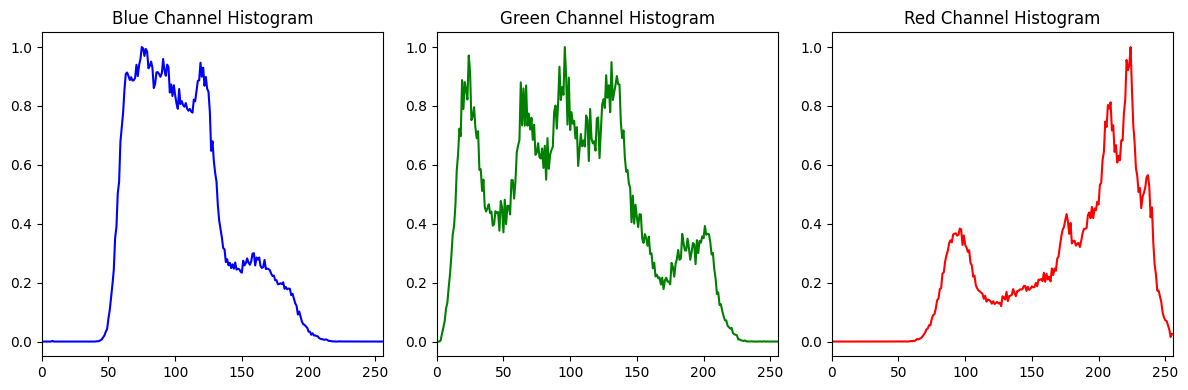

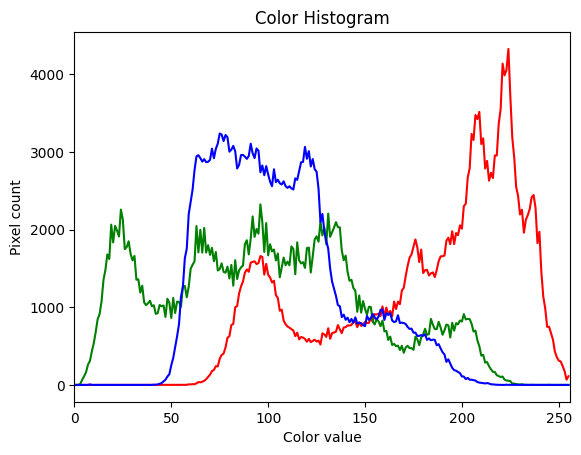

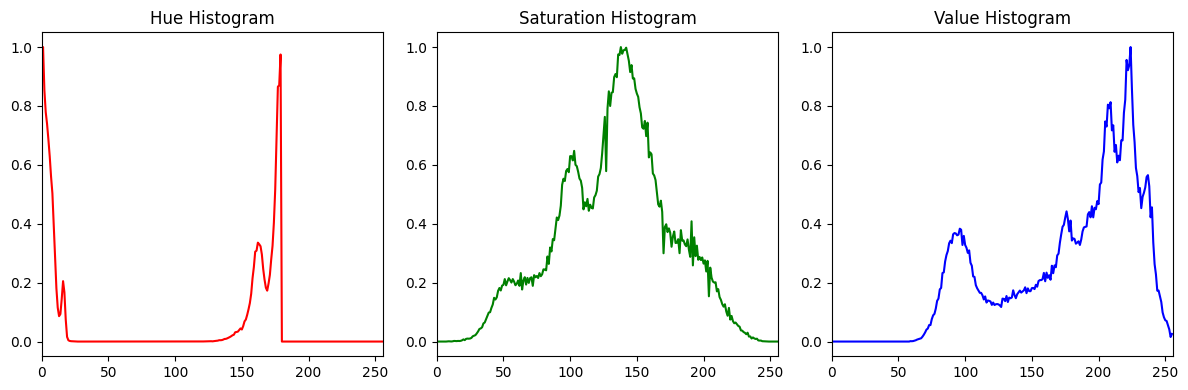

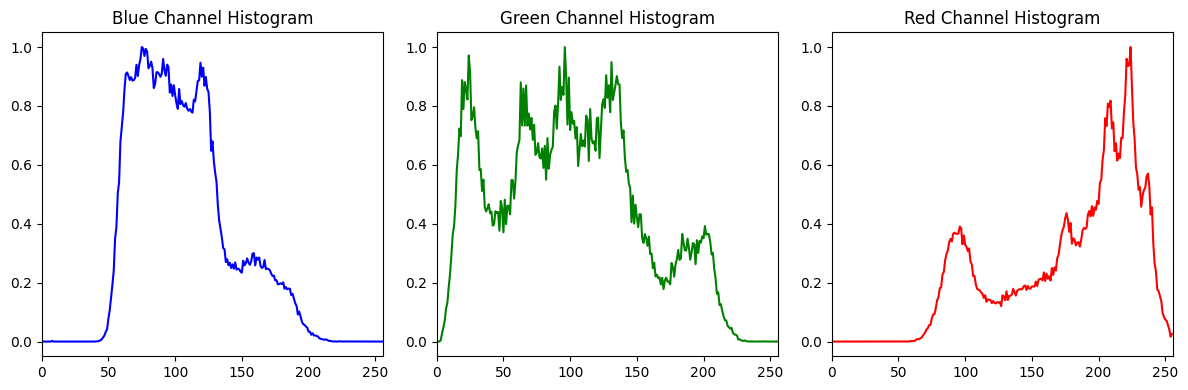

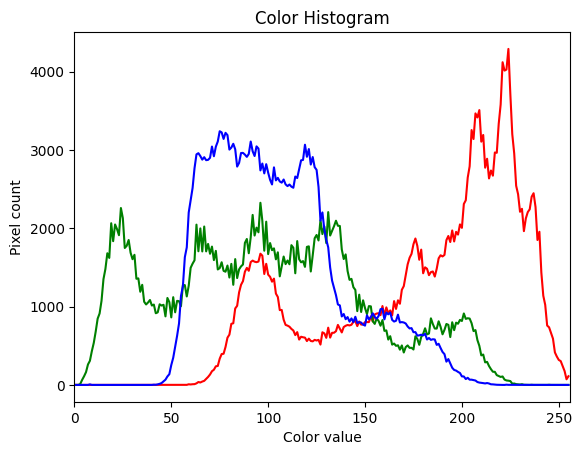

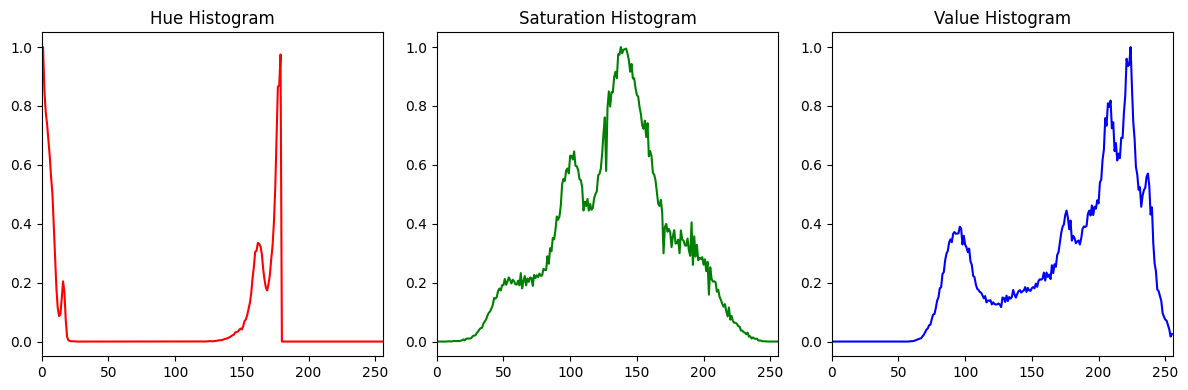

In [73]:
analyse(original_image)